# Summary
In Season 12, the strike zone formula is this:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.90,
                 minroll
                 + 0.35*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 13, the strike zone formula is modified. The The max possible value for a strike goes DOWN from 0.90 to 0.85, and the ruthlessness coefficient goes DOWN from 0.35 to 0.30. This formula holds for Season 13 and Season 14:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.85,
                 minroll
                 + 0.3*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 15, the strike zone formula changes slightly *again*. The max possible value for a strike goes UP from 0.85 to 0.86, and the ruthlessness coefficient goes DOWN from 0.3 to 0.285 (a 5% decrease):
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.86,
                 minroll
                 + 0.285*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```


In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

In [2]:
all_files = glob.glob("roll_data/*-strikes.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string"}) for f in all_files), ignore_index=True)

# select season (zero indexed)
# seasons = [11,12,13,14]
season = 13
df = df[df['season'] == season]


flinch_data = True

## Helper function definitions

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass # sometimes traveling doesn't do anything on pitchers, but not always
        # if not row["top_of_inning"]:
            # mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        pass # sometimes growth doesn't do anything on pitchers, but not always
        # mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # Did anyone with this mod *ever* pitch???
        mul += 0.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        # pass
        if row["top_of_inning"]:
            mul += 0.05
    if "GROWTH" in btm:
        # pass
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "ON_FIRE" in bm:
        # todo: handle properly, which requires figuring out how it works, which sucks
        # mul += 1.25
        pass
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        mul += 0.50
    return mul

## Apply multipliers to data

In [4]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

df["ruth_scaled"] = df["pitcher_ruthlessness"] * df["pitcher_mul"]
df["musc_scaled"] = df["batter_musclitude"] * df["batter_mul"]

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [5]:
# recenter ballpark factors: subtract 0.5
for attr in ['ballpark_grandiosity',
             'ballpark_fortification',
             'ballpark_obtuseness',
             'ballpark_ominousness',
             'ballpark_inconvenience',
             'ballpark_viscosity',
             'ballpark_forwardness',
             'ballpark_mysticism',
             'ballpark_elongation',
            ]:
    df[attr] -= 0.50


In [6]:
df = df[(df["batting_team_hype"] == 0) & (df["pitching_team_hype"] == 0)]

df["ruth_times_vibes"] = df["ruth_scaled"] * df["pitcher_vibes"]
df["ruth_vibes"] = df["ruth_scaled"] * (1 + 0.2 * df["pitcher_vibes"])

# put in our "best fit" up here in the original df, just because
if season == 11:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.35 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
elif season == 12 or season == 13:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.30 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
elif season == 14:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.285 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]

using season 14 formula


## Exclude data
Handles swapping between flinch and no-flinch situations, and excluding things like ON_FIRE.

In [7]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]
dfc = df.copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in ["ON_FIRE"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    #     dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    #     dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc["flinch"] = (dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0)
    if flinch_data:
        dfc = dfc[dfc["flinch"]]
    else:
        dfc = dfc[~dfc["flinch"]]
#     dfc["flinch"] = dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)
dfc.groupby("flinch").size()

flinch
True    8180
dtype: int64

In [8]:
print(list(df.columns))
print(len(df))
print(len(dfc))

['event_type', 'roll', 'passed', 'batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon', 'batter_multiplier', 'runner_on_first_base_thirst', 'runner_on_first_continuation', 'runner_on_first_ground_friction', 'runner_on_first_indulgence', 'runner_on_first_laserlikeness', 'runner_on_first_multiplier', 'runner_on_second_base_thirst', 'runner_on_second_continuation', 'runner_on_second_ground_friction', 'runner_on_second_indulgence', 'runner_on_second_laserlikeness', 'runner_on_s

In [9]:
digest_list = [
    "event_type",
    "roll",
    "batter_name",
    "pitcher_name",
    "ruth_scaled",
    "pitcher_vibes",
    "musc_scaled",
    "ballpark_forwardness",
    "game_id",
    "play_count",
    "svc_best",
]

In [10]:
# old weighting functions, not using these

# dfc['svc'] = 0.37847946767478163 * dfc["pitcher_ruthlessness"] + 0.30163948661504275 * dfc["ballpark_forwardness"]
# # df['svc_vibes'] = 0.3570080647613859*df["pitcher_ruthlessness"] + 0.23460353690794863*df["ballpark_forwardness"] \
# #                   + 0.06376601180181157*df["pitcher_vibes"]
# dfc['svc_vibes'] = 0.35 * dfc["pitcher_ruthlessness"] + 0.25 * dfc["ballpark_forwardness"] \
#                   + 0.05 * dfc["pitcher_vibes"]
# dfc['svc_musc'] = 0.31647362 * dfc["pitcher_ruthlessness"] + 0.20359297 * dfc["ballpark_forwardness"] \
#                   + 0.05434203 * dfc["pitcher_vibes_multiplied"] + 0.09587699 * dfc["batter_musclitude"]
# dfc['batter_strikeattr'] = dfc['batter_moxie'] * ~dfc['passed'] + dfc['batter_patheticism'] * dfc['passed']
# dfc['ruth_and_fwd'] = dfc['pitcher_ruthlessness'] - 0.5 * dfc['ballpark_forwardness']
# dfc['ruth_and_fwd'] = dfc['pitcher_ruthlessness'] - 0.5 * dfc['ballpark_forwardness']

### Preliminary plot

In [11]:
# # x_val = "ruth_scaled"
# x_val = "svc_best"
# fig, ax = plt.subplots(1, figsize=(10, 10))
# ax.scatter(
#     dfc[~dfc["passed"]][x_val],
#     dfc[~dfc["passed"]]["roll"],
#     color="red",
#     label="Balls",
#     marker=CARETLEFTBASE,
# )
# ax.scatter(
#     dfc[dfc["passed"]][x_val],
#     dfc[dfc["passed"]]["roll"],
#     color="blue",
#     label="Strikes",
#     marker=CARETRIGHTBASE,
# )
# ax.set_xlabel(x_val)
# ax.set_ylabel("roll")
# # ax.set_xlim(0.484, 0.499)

# ax.legend()

# fig.savefig(x_val + ".png", facecolor="white")

In [12]:
dfc.groupby(["batting_team_mods"]).size()

batting_team_mods
CARCINIZATION;UNHOLEY               3377
CARCINIZATION;UNHOLEY;FREE_WILL      280
CARCINIZATION;UNHOLEY;PARTY_TIME    1106
SINKING_SHIP                         566
SINKING_SHIP;PARTY_TIME              110
TRAVELING                           2267
TRAVELING;PARTY_TIME                 474
dtype: int64

## SVC fit

In [13]:
# X = dfc[['passed', 'roll', 'ruth_vibes', 'ballpark_forwardness', 'musc_scaled']].copy()
X = dfc[["passed", "roll", "ruth_vibes", "ballpark_forwardness", "musc_scaled"]].copy()
X = X[X["roll"] < 0.85]
# X["roll"] = X["roll"] - 0.2 * X["ballpark_forwardness"]
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X["passed"]
X = X.drop(["passed"], axis=1)

In [14]:
X["roll"].max()
X.shape

(6881, 4)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))

[[ 462    0]
 [   0 6419]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       462
        True       1.00      1.00      1.00      6419

    accuracy                           1.00      6881
   macro avg       1.00      1.00      1.00      6881
weighted avg       1.00      1.00      1.00      6881



In [16]:
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)

1.0

In [17]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]

print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.49614611]


[(1.0, 'roll'),
 (-0.3024009641275508, 'ruth_vibes'),
 (-0.1969934173965793, 'ballpark_forwardness'),
 (-0.10535611693507917, 'musc_scaled')]

## Calculate threshold from fit

In [18]:
if flinch_data:
    intercept = 0.50
else:
    intercept = 0.30
if season == 11:
    dfc["threshold"] = (intercept
                        + 0.35 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.90
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season == 12 or season == 13:
    dfc["threshold"] = (intercept
                        + 0.30 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.85
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season == 14:
    dfc["threshold"] = (intercept
                        + 0.285 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
# dfc['threshold'] = -intercept_scaled[0]
# print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] != "roll":
#         print(pair)
#         dfc['threshold'] += pair[0] * dfc[pair[1]]
# dfc['threshold'] += 0.2 * dfc['ballpark_forwardness']


# dfc['svc'] = 0
# # print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] != "roll":
#         # print(pair)
#         dfc['svc'] += pair[0] * dfc[pair[1]]
# dfc['svc'] += 0.2 * dfc['ballpark_forwardness']

In [19]:
dfc_strikes = dfc[dfc["event_type"] == "StrikeLooking"]
dfc_flinch = dfc[dfc["event_type"] == "StrikeFlinching"]
dfc_balls = dfc[dfc["event_type"] == "Ball"]

In [20]:
dfc_flinch["roll"].max()

0.8497483718665839

## Find Outliers

,offset,pitcher_mul,batter_mul,event_type,roll,threshold,ruth_vibes,batter_musclitude,ballpark_forwardness,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count,weather


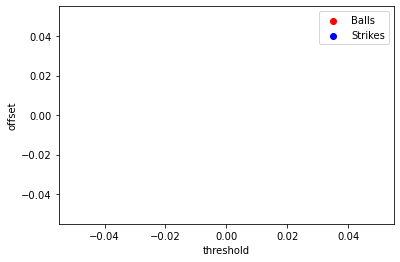

In [21]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Balls",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Strikes",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
table[
    [
        "offset",  # "home_score", "away_score", "top_of_inning", "inning",
        "pitcher_mul",
        "batter_mul",
        "event_type",
        "roll",
        "threshold",
        "ruth_vibes",
        "batter_musclitude",
        "ballpark_forwardness",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
        "weather",
         # 'ball_count',
         # 'strike_count',
         # 'out_count'
    ]
].sort_values("roll")

## Visualize Threshold

Text(0.5, 0.98, 'Season 14, Flinching')

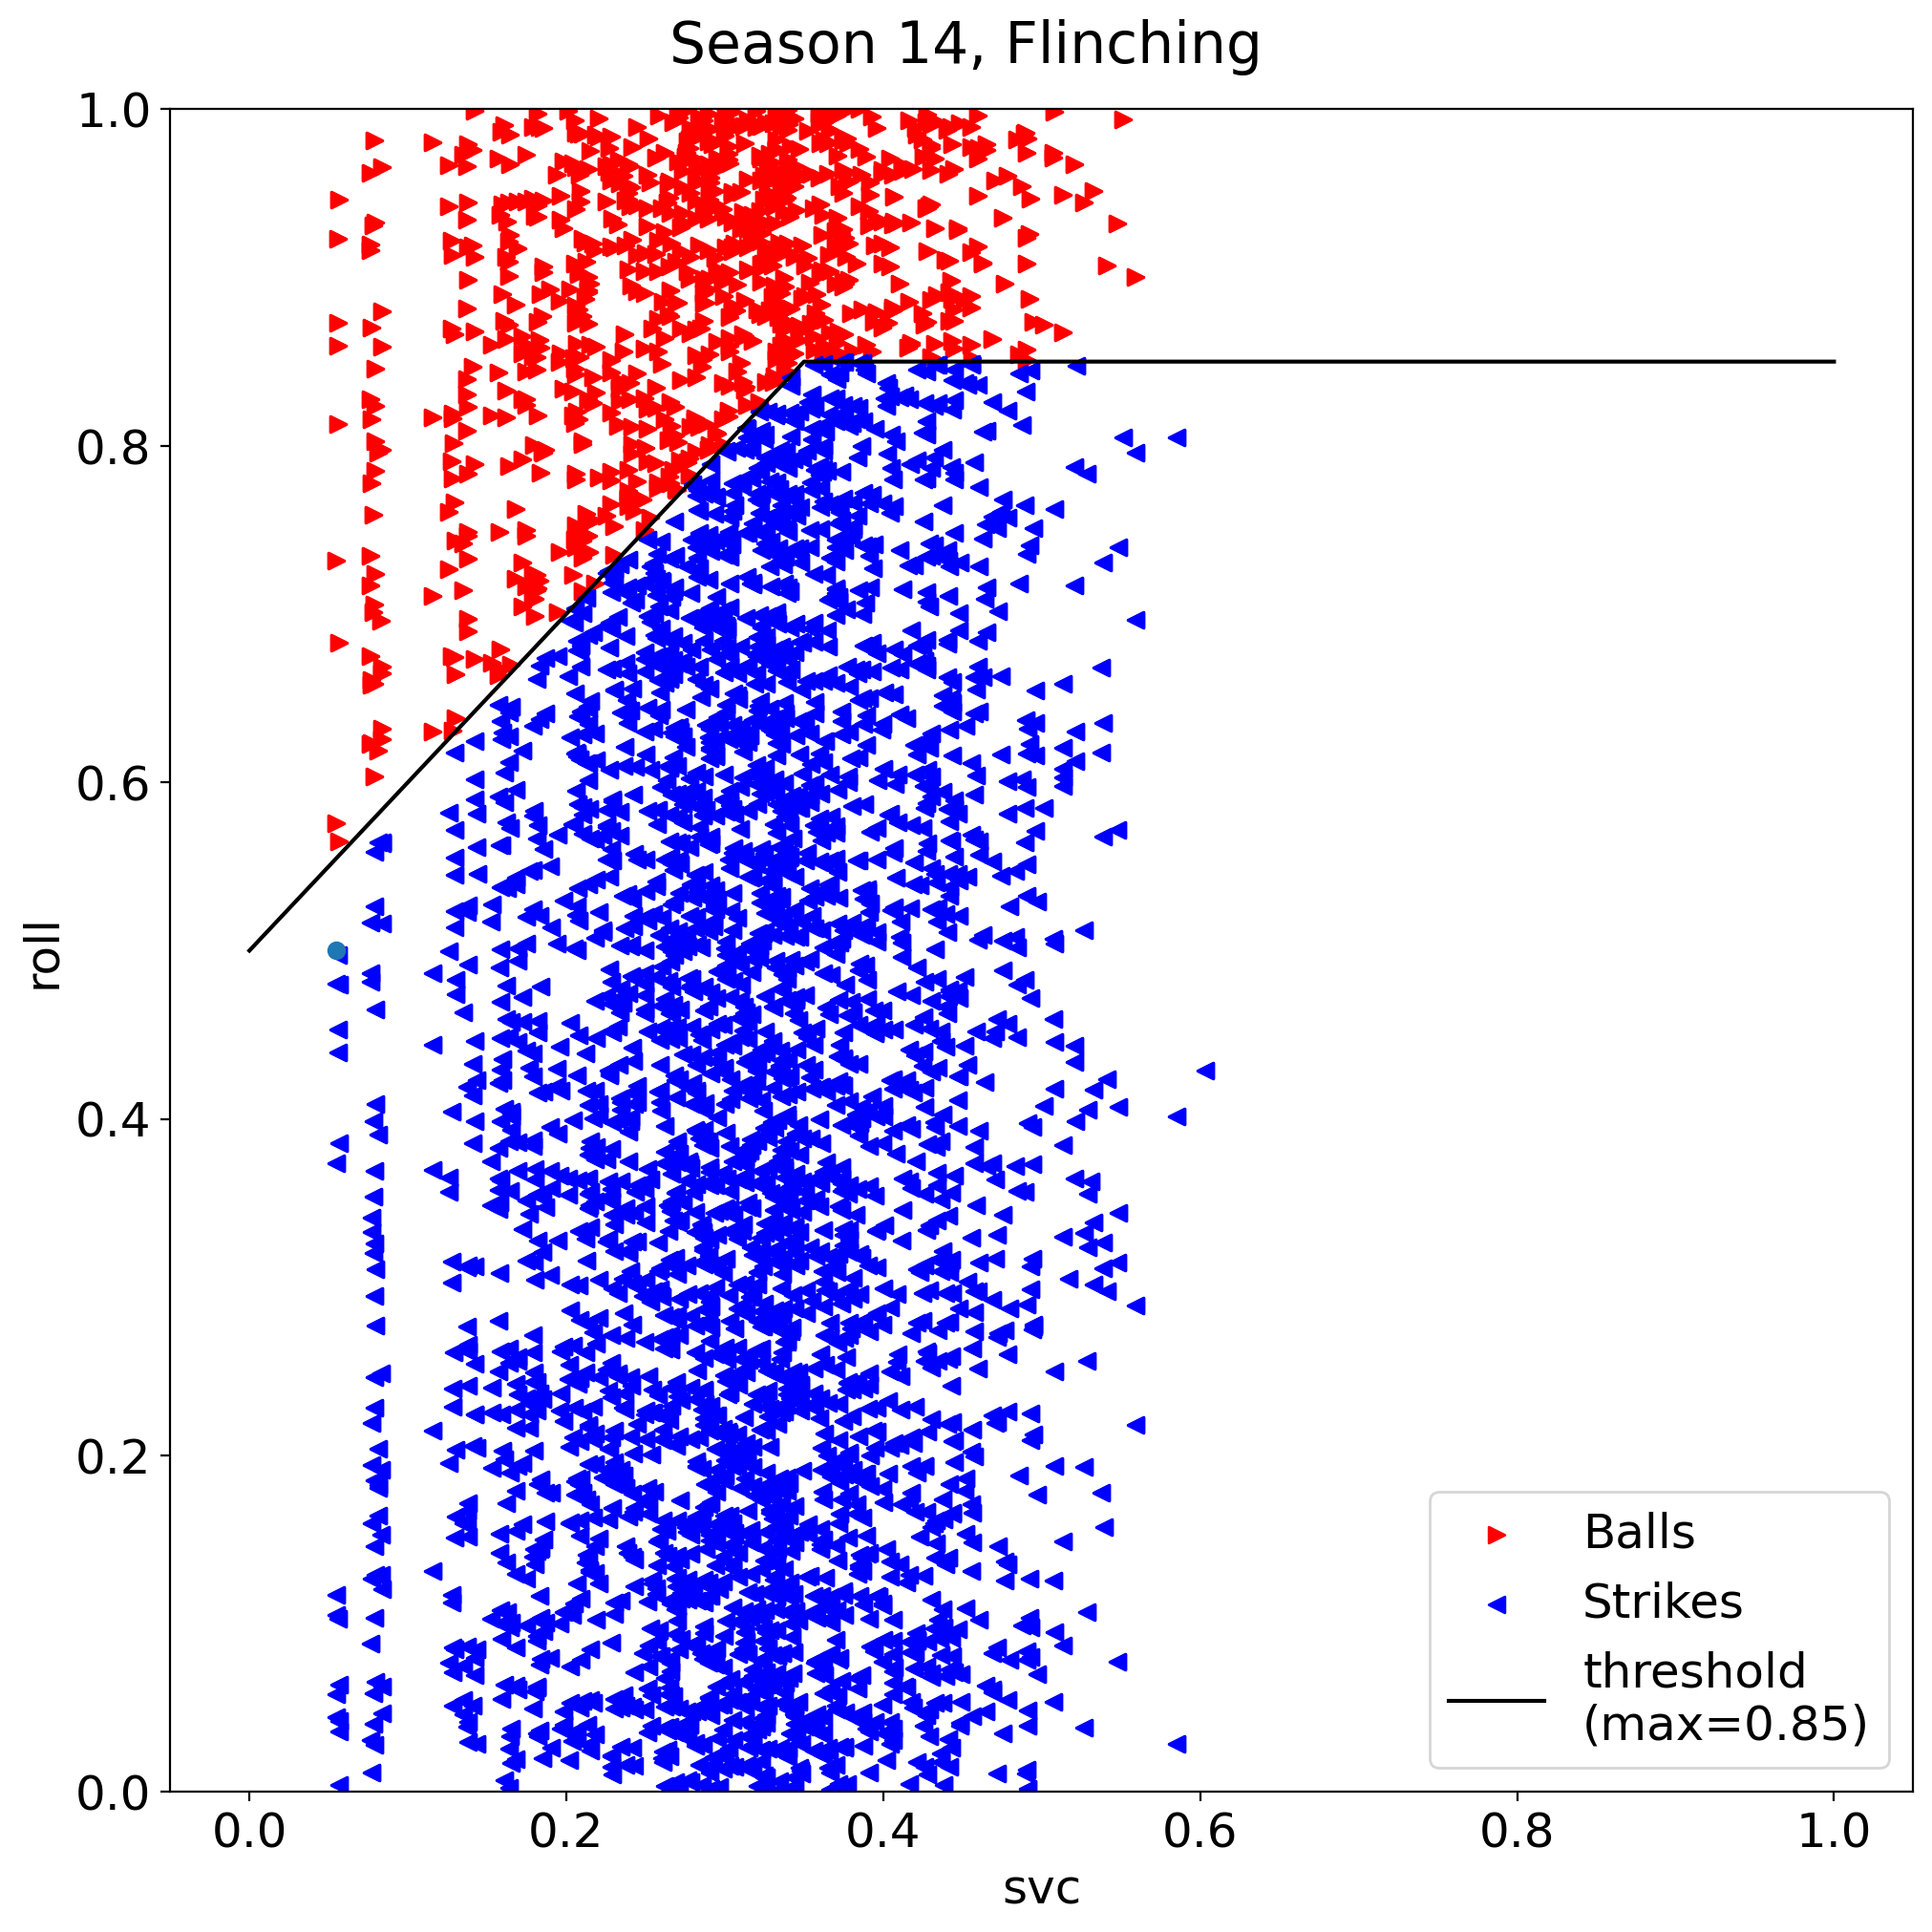

In [22]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "svc"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

intercept_plot = intercept
# intercept_plot = -intercept_scaled
xline = np.linspace(0, 1, 201)
# xline = np.insert(xline, 1, 0.65)
yline = intercept_plot + xline
yline[(yline > strikemax)] = strikemax

# ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Balls",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Strikes",
    marker="<",
)
# ax.set_xlim(-0.05, 1.05)
ax.plot(xline, yline, "k", label=f"threshold\n(max={strikemax})")
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="red", label="Balls (below threshold)", marker='<')
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="blue", label="Strikes (above threshold)", marker='>')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.plot(dfc["svc"].min(), 0.5, 'o')

ax.legend(loc="lower right")
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching")
# fig.savefig(f"./figures/strikes_s{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white', dpi=200)


In [23]:
outliers.groupby("season").size()

Series([], dtype: int64)

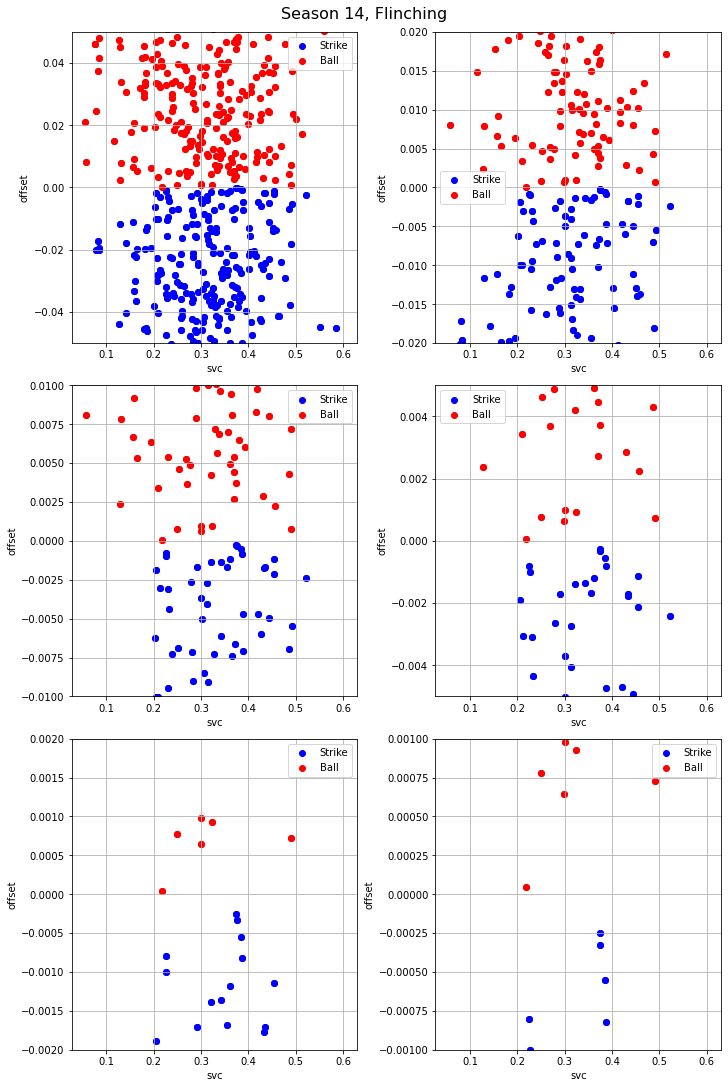

In [24]:
plt.rcParams["font.size"] = 10
x_val = "svc"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig(f"./figures/ball_strike_fit_offsets_season{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white')


In [25]:
# cutoff = 0.85 + intercept_scaled[0]
cutoff = 0.85 - intercept
print(round(cutoff, 6))
print(dfc_balls['roll'].max())
print(dfc_flinch['roll'].max())
print(dfc_strikes['roll'].max())
print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].min())
print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin())
dfc_balls[dfc_balls['svc'] > cutoff].iloc[dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin(),:]
# print(dfc_flinch[dfc_flinch['svc'] > 0.85 + intercept_scaled[0]]['roll'].max())

0.35
0.9999127181619892
0.8497483718665839
nan
0.850726287129669
272


event_type             Ball
roll               0.850726
passed                False
batter_buoyancy     1.03484
batter_divinity    0.942069
                     ...   
ruth_vibes         1.098955
svc_best           0.490522
flinch                 True
threshold              0.85
svc                0.490522
Name: 223186, Length: 146, dtype: object

In [26]:
print(dfc_balls['roll'].min())
print(dfc_flinch['roll'].min())
print(dfc_strikes['roll'].min())

0.5648839101058007
0.0008941042939796
nan


In [27]:
0.85 + intercept_scaled[0]

0.3538538923564801

In [28]:
# df["svc"].min()

In [29]:
# df["svc_best"].max()

In [30]:
# df.iloc[df["svc_best"].argmax(), :][70:]

In [31]:
# dfc["threshold"] = -1 * (\
#     1.0 * -0.20 + \
#     -0.30 * dfc["ruth_scaled"] + \
#     -0.20 * dfc["ballpark_forwardness"] + \
#     -0.10 * dfc["musc_scaled"] + \
#     -0.06 * dfc["ruth_vibes"])
# dfc["threshold"] = -1 * (\
#     coef_scaled[0,0] * intercept_scaled + \
#     coef_scaled[0,1] * dfc["ruth_scaled"] + \
#     coef_scaled[0,2] * dfc["ballpark_forwardness"] + \
#     coef_scaled[0,3] * dfc["ruth_vibes"] + \
#     coef_scaled[0,4] * dfc["musc_scaled"] + \
#     coef_scaled[0,5] * dfc["flinch"])
# dfc.loc[(dfc["threshold"] > 0.85), "threshold"] = 0.85


# dfc["offset"] = dfc["roll"] - dfc["threshold"]

# outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
# print(len(outliers))

# fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 10)
# x_val = "svc"
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="Balls")
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Strikes")
# ax.set_xlabel(x_val)
# ax.set_ylabel('offset')
# ax.grid()
# ax.legend()
# ax.set_xlim(0, 1.4)
# ax.set_xlim(0.1, 0.7)
# ax.set_ylim(-0.06, 0.08)
# fig.savefig("fit_outliers.png", facecolor='white')

In [32]:
dfc_flinch.loc[:,["roll", "ruth_vibes", "pitcher_name", "svc"]].sort_values("ruth_vibes")

,roll,ruth_vibes,pitcher_name,svc
154543,0.092593,0.107985,Simba Davis,0.181584
154252,0.087949,0.107985,Simba Davis,0.076486
154556,0.219065,0.107985,Simba Davis,0.077296
154365,0.480589,0.107985,Simba Davis,0.054458
154384,0.164227,0.107985,Simba Davis,0.081541
...,...,...,...,...
140061,0.597926,1.518531,Gabriel Griffith,0.513578
139337,0.330134,1.518531,Gabriel Griffith,0.513578
139513,0.086796,1.518531,Gabriel Griffith,0.513578
194126,0.658683,1.518531,Gabriel Griffith,0.513578


In [33]:
dfc_flinch["svc"].min()

0.05445817690493793